## Booking prediction

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand



## Pontos esperados:
1) Apresente as características do conjunto de dados fornecido, destacando sua visão geral acerca do conjunto de dados e tecendo críticas e comentários.;

2) Faça uma análise detalhada das variáveis numéricas e categóricas da base de dados, discutindo sua distribuição e outras características relevantes;

3) Limpeza de dados: Considere a avaliação da existência de valores ausentes e de possíveis outliers, discutindo como estes podem ser tratados ou eliminados;

4) Feature engineering: Quais variáveis você poderia criar para enriquecer a análise?

5) Enriquecimento da base: Inclua qualquer outra informação/análise que achar importante.

6) Que outras bases externas ou internas voce buscaria para enriquecer as análises?

7) Quais os pré-processamentos aplicados e o porquê.

8) Quais modelos escolhidos e o porquê da escolha desses modelos.

9) Quais outras melhorias poderiam ser feitas tanto nos dados quanto em relação à modelagem?

10) Quais métricas foram escolhidas e o porquê.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("hotel_bookings.csv")
df.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
# NaNs
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
# Os dados estão desbalanceados?
df["is_canceled"].value_counts(normalize = True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [14]:
# Clean e transform

# drop columns
df_clean = df.drop(columns=['reservation_status_date', 'company', 'arrival_date_week_number', 'reservation_status',
                            'arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_week_number'])

# ajustar children 
df_clean['children'].fillna(0, inplace=True)
df_clean['children'] = pd.to_numeric(df_clean['children'], errors='coerce')

# top5 countries
top5_country = list(df_clean['country'].value_counts()[:5].index)
df_clean['country'] = df_clean.country.where(df.country.isin(top5_country), 'OTHERS')

# top5 agents
top5_agent = list(df_clean['agent'].value_counts()[:5].index)
df_clean['agent'] = df_clean.country.where(df.country.isin(top5_agent), 'OTHERS')
df_features = df_clean.copy()

# total guests
df_features['total_guests'] = df_features['children'] + df_features['babies'] + df_features['adults']
df_features.drop(columns=['children', 'babies', 'adults'], inplace=True)
df_features['total_guests'] = df_features['total_guests'].apply(np.int64)

# stays_in_total
df_features['stayes_in_total'] = df_features["stays_in_weekend_nights"] + df_features["stays_in_week_nights"]
df_features.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], inplace=True)

# cancellation_rate
df_features['cancellation_rate'] = df_features["previous_cancellations"] / (df_features["previous_cancellations"] + df_features["previous_bookings_not_canceled"])
df_features['cancellation_rate'].replace(np.nan, 0, inplace=True)
df_features.drop(columns=['previous_cancellations', 'previous_bookings_not_canceled'], inplace=True)

# assigned_as_reserved
df_features['assigned_as_reserved'] = (df_features["assigned_room_type"] == df_features["reserved_room_type"])*1
df_features.drop(columns=['assigned_room_type', 'reserved_room_type'], inplace=True)

In [15]:
df = df_features.copy()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        119390 non-null  object 
 1   is_canceled                  119390 non-null  int64  
 2   lead_time                    119390 non-null  int64  
 3   arrival_date_month           119390 non-null  object 
 4   meal                         119390 non-null  object 
 5   country                      119390 non-null  object 
 6   market_segment               119390 non-null  object 
 7   distribution_channel         119390 non-null  object 
 8   is_repeated_guest            119390 non-null  int64  
 9   booking_changes              119390 non-null  int64  
 10  deposit_type                 119390 non-null  object 
 11  agent                        119390 non-null  object 
 12  days_in_waiting_list         119390 non-null  int64  
 13 

In [17]:
df.isna().sum().sum()

0

---

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split, cross_validate

X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_train

,hotel,lead_time,arrival_date_month,meal,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,stayes_in_total,cancellation_rate,assigned_as_reserved,is_canceled
67702,City Hotel,64,May,BB,GBR,Online TA,TA/TO,0,0,No Deposit,...,0,Transient,189.00,0,0,3,3,0.000000,1,1
115851,City Hotel,34,July,BB,FRA,Direct,Direct,0,0,No Deposit,...,0,Transient,146.00,0,0,3,2,0.000000,1,0
57345,City Hotel,8,September,BB,ESP,Online TA,TA/TO,0,0,No Deposit,...,0,Transient,259.00,0,0,4,2,0.000000,1,1
11622,Resort Hotel,251,May,BB,FRA,Direct,Direct,0,0,No Deposit,...,0,Transient,89.70,0,1,2,6,0.000000,1,1
33333,Resort Hotel,23,February,BB,GBR,Online TA,TA/TO,0,0,No Deposit,...,0,Transient,42.43,0,1,2,2,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,City Hotel,2,July,BB,PRT,Corporate,Corporate,1,1,No Deposit,...,0,Transient,77.00,1,0,2,1,0.333333,1,0
110268,City Hotel,91,April,BB,OTHERS,Online TA,TA/TO,0,0,No Deposit,...,0,Transient,135.00,0,0,2,5,0.000000,1,0
103694,City Hotel,74,December,BB,OTHERS,Offline TA/TO,TA/TO,0,0,No Deposit,...,0,Transient,92.65,0,0,3,3,0.000000,1,0
860,Resort Hotel,130,August,BB,PRT,Online TA,TA/TO,0,0,No Deposit,...,0,Transient,120.60,0,2,2,7,0.000000,1,1


## Preprocessing - Tipos de colunas

In [ ]:
# Separar as colunas 
colunas_numericas = list(X_train.select_dtypes(include='number').columns)
colunas_categoricas =  list(X_train.select_dtypes(exclude='number').columns)

In [106]:
# SMOTENC  utliza uma lista de indexes da lista de colunas
categorical_features = list(np.array([i for i,x in enumerate(X_train.columns) if x in colunas_categoricas]))
categorical_features

In [109]:
# oversampling
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features = categorical_features)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [117]:
# Balanceamento de dados
y_train.value_counts()

0    60259
1    60259
Name: is_canceled, dtype: int64

In [110]:
# Transform das features de train
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False)
# fitar e transformar as features de treino 
X_train_enc = ohe.fit_transform(X_train[colunas_categoricas])
X_train_enc = pd.DataFrame(X_train_enc, columns=ohe.get_feature_names_out(colunas_categoricas))
X_train = X_train.reset_index(drop=True)
X_train = pd.concat([X_train[colunas_numericas], X_train_enc], axis=1)
X_train
# target já está em numerico

,lead_time,is_repeated_guest,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,stayes_in_total,cancellation_rate,...,distribution_channel_TA/TO,distribution_channel_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,agent_OTHERS,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,64,0,0,0,189.00,0,0,3,3,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34,0,0,0,146.00,0,0,3,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,8,0,0,0,259.00,0,0,4,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,251,0,0,0,89.70,0,1,2,6,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,23,0,0,0,42.43,0,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120513,50,0,0,0,200.00,0,1,2,4,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
120514,88,0,0,0,170.00,0,0,2,4,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
120515,0,0,0,0,12.00,0,0,2,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
120516,92,0,0,0,79.20,0,1,2,3,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [111]:
X_train.isna().sum().sum()

0

In [112]:
# Transformar as features de teste
X_test = X_test.reset_index(drop=True)
X_test_enc = ohe.transform(X_test[colunas_categoricas])
X_test_enc = pd.DataFrame(X_test_enc, columns=ohe.get_feature_names_out(colunas_categoricas))
X_test = pd.concat([X_test[colunas_numericas], X_test_enc], axis=1)
X_test

,lead_time,is_repeated_guest,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,stayes_in_total,cancellation_rate,...,distribution_channel_TA/TO,distribution_channel_Undefined,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,agent_OTHERS,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,203,0,4,0,66.80,0,0,2,7,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,82,0,0,0,76.50,0,0,2,3,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,25,0,2,0,60.00,0,1,3,3,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,0,0,0,95.00,0,0,1,1,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,70,0,0,0,108.00,0,0,2,4,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23873,251,0,0,93,90.00,0,0,1,3,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
23874,152,0,0,0,48.98,0,0,2,7,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
23875,40,0,1,0,55.00,0,0,1,3,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
23876,109,0,0,0,102.25,0,0,2,5,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [17]:
X_test.isna().sum().sum()

0

## Decision Tree Classifier

In [113]:
from sklearn.tree import DecisionTreeClassifier, plot_tree 

# Instância modelo de classificação
model = DecisionTreeClassifier(max_depth = 10, random_state = 42)
# Podei em max_depth = 10, pq deixar None leva a overfitting
# Treina o modelo
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [114]:
# Prediz nos dados de teste
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

Accuracy Score of Decision Tree is : 83.86 %

Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14907
           1       0.78      0.79      0.79      8971

    accuracy                           0.84     23878
   macro avg       0.83      0.83      0.83     23878
weighted avg       0.84      0.84      0.84     23878


Matriz de Confusão


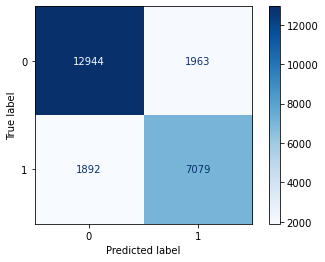

In [115]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

acc_dtc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

print(f"Accuracy Score of Decision Tree is : {100*acc_dtc:.2f} %")
print()
print(f"Classification Report : \n{clf_report}")
print()
print("Matriz de Confusão")
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

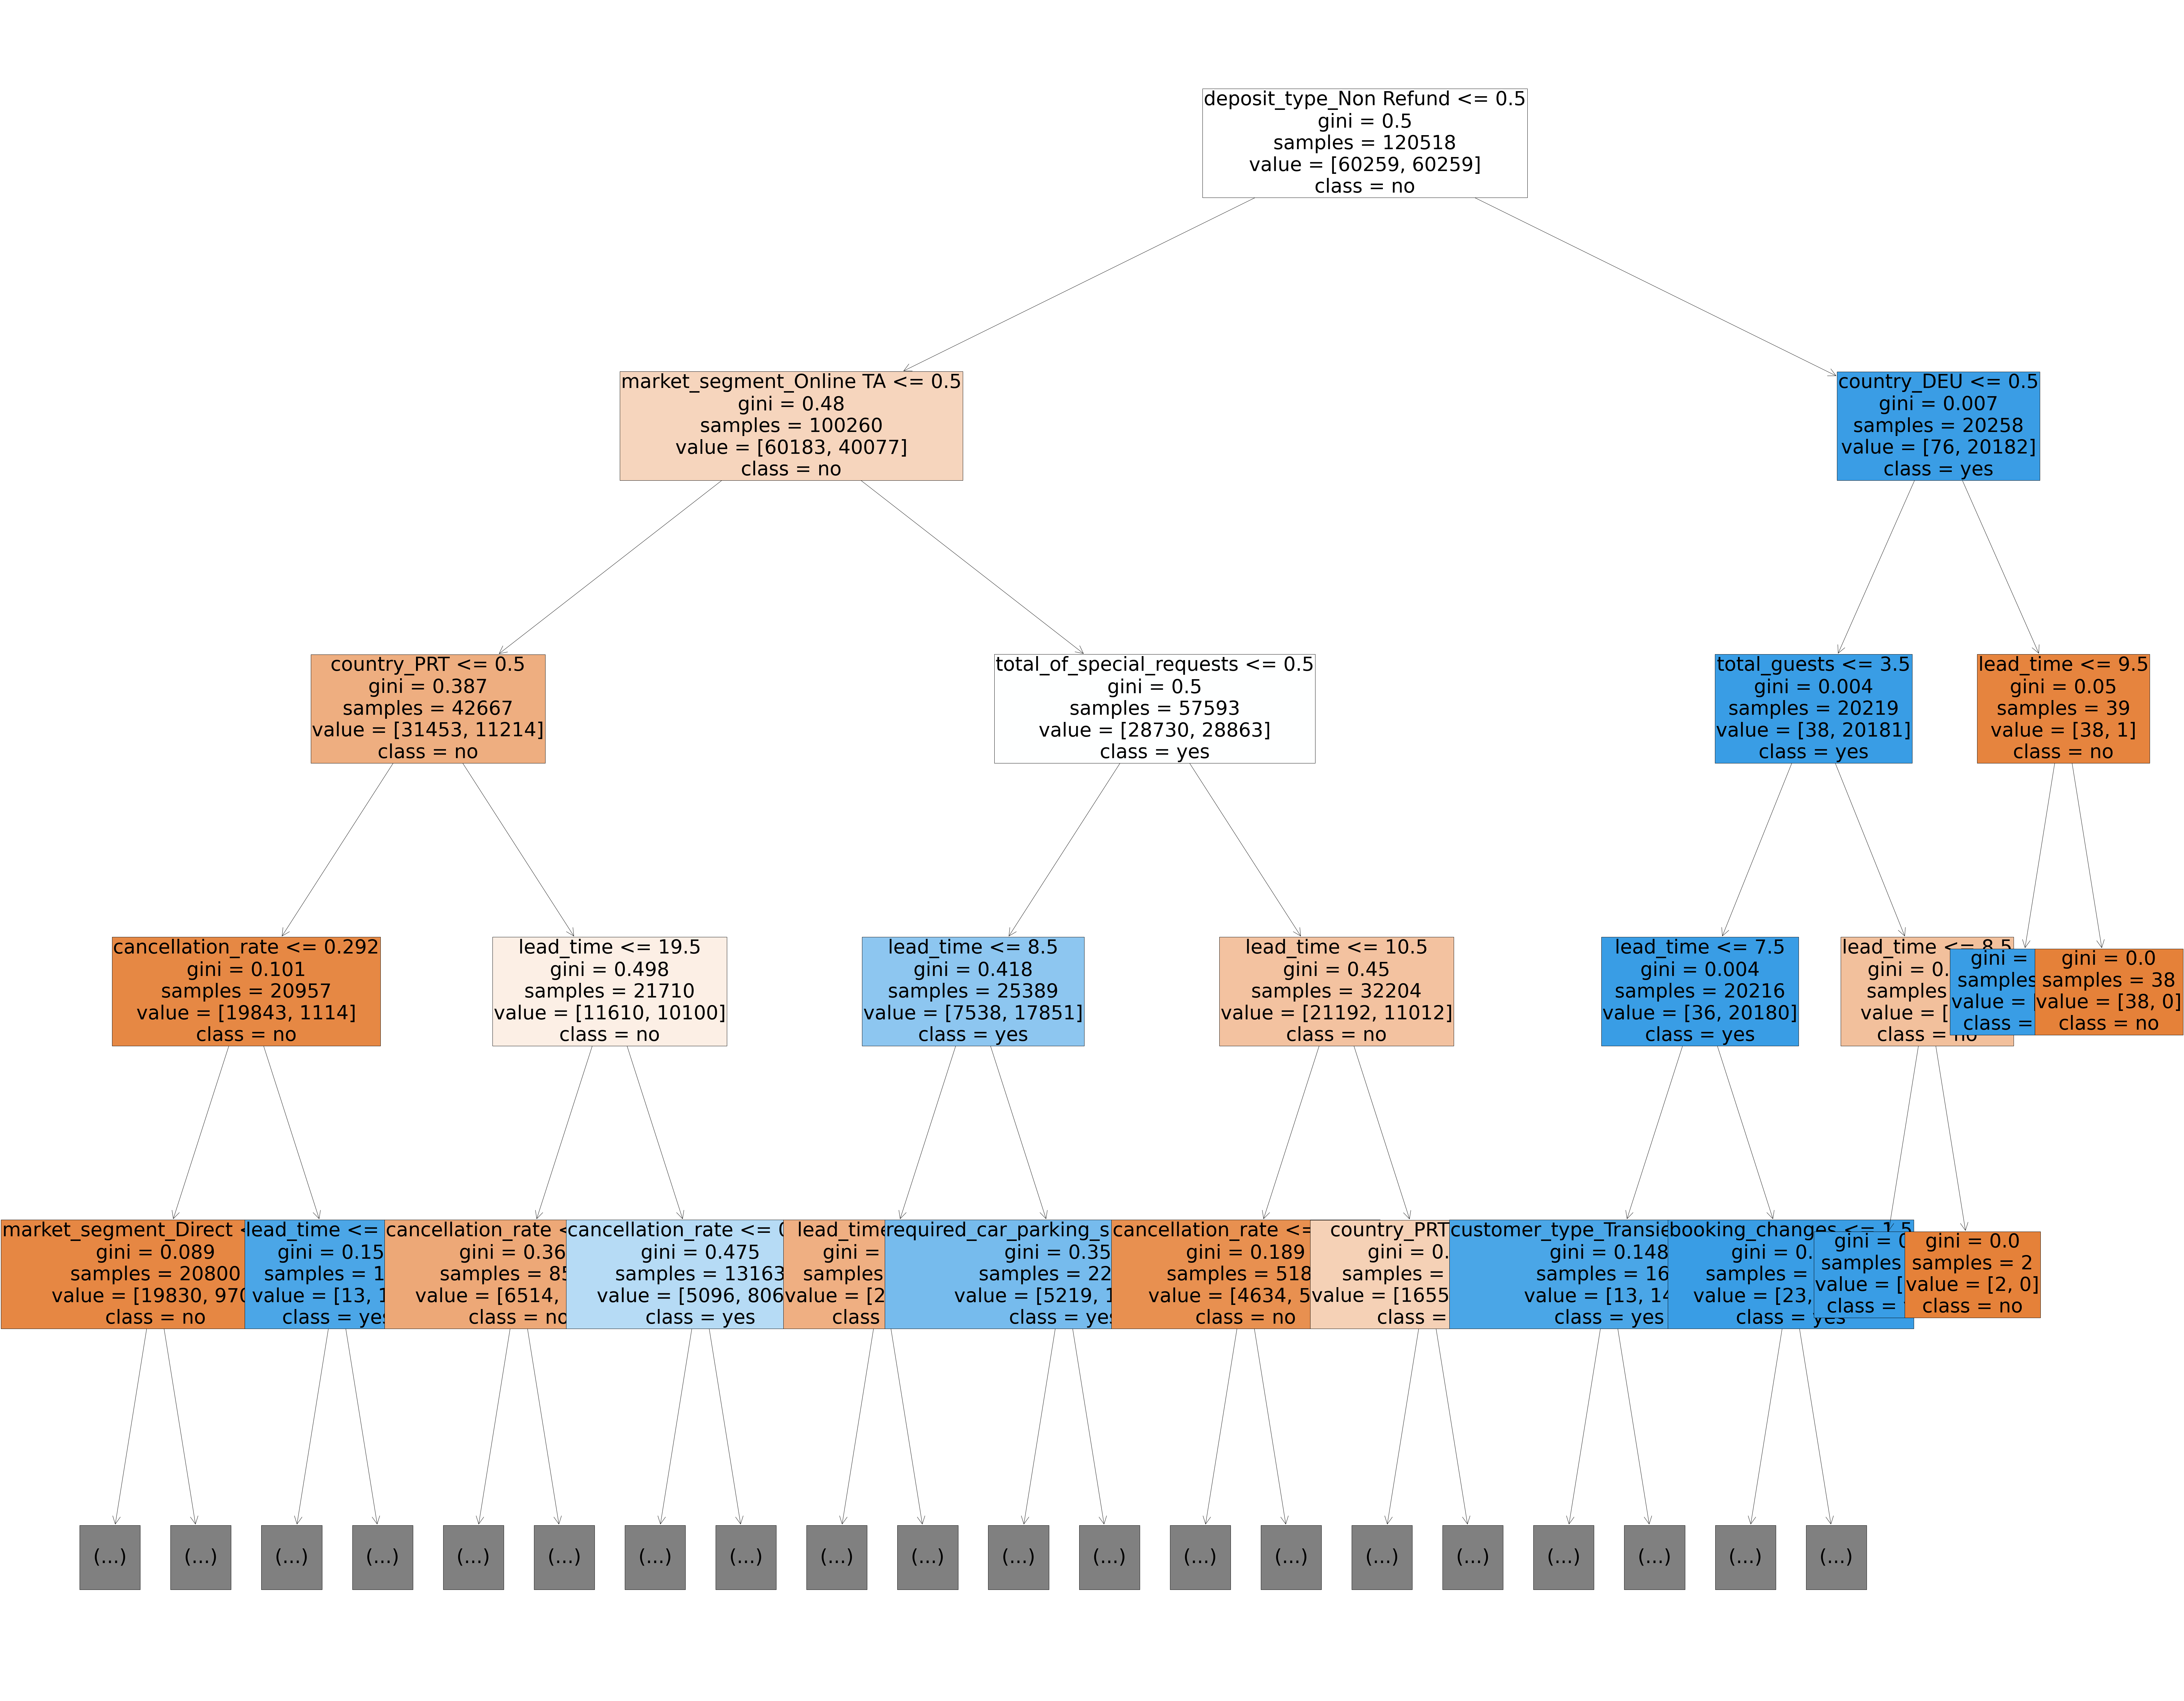

In [116]:
# Árvore de Decisão
plt.figure(figsize=(120, 100))
plot_tree(model, max_depth=4, class_names=['no', 'yes'], fontsize=62, feature_names=X_train.columns, filled=True)
plt.show()

## Cross validation de Decision Tree Classifier

In [156]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [157]:
# Faz a validação cruzada - usando o mesmo modelo
results_no_optim = cross_validate(model,
                                  X_train, 
                                  y_train, 
                                  scoring='accuracy', 
                                  return_train_score=True,
                                  cv=kfold)

In [158]:
# Dos scores de "results_no_optim"
print(f" Acurácia treino: {100*results_no_optim['train_score'].mean():0.1f}")
acc_sem_otimizacao = results_no_optim['test_score'].mean()
print(f" Acurácia na validação: {100*acc_sem_otimizacao:0.1f}")

# Parece overfitado

 Acurácia treino: 84.6
 Acurácia na validação: 84.2


In [159]:
# Faz o fit nos dados de treino
model.fit(X_train, y_train)
# Faz a predição no teste
y_pred = model.predict(X_test)

print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred):0.1f}")

 Acurácia teste: 83.9


In [121]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

## Random Search

In [160]:
# Critério do split
criterions = ['gini', 'entropy']

# Profundidades máximas que iremos testar
max_depth = list(np.arange(10, 14))

# Número de pontos mínimos necessário para permitir um split no nó
min_samples_split = np.arange(1, 6)

# Número de pontos mínimos que podem existir em cada folha (nó final)
min_samples_leaf = np.arange(2, 8)

# Grid de escolhas
params_grid = {'criterion': ['gini', 'entropy'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

params_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 11, 12, 13],
 'min_samples_split': array([1, 2, 3, 4, 5]),
 'min_samples_leaf': array([2, 3, 4, 5, 6, 7])}

In [161]:
from sklearn.model_selection import RandomizedSearchCV

model_random = DecisionTreeClassifier(max_depth=2, random_state=42)
random_search = RandomizedSearchCV(model_random, 
                                   scoring='accuracy', 
                                   cv=kfold, 
                                   return_train_score=True,
                                   n_iter=50, 
                                   param_distributions=params_grid, 
                                   verbose=2)

In [162]:
%%time
# Faz o fit do random_search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2; total time=   1.0s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=3, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.8s
[CV] END criterion=gini, max_depth=10, min_samp

[CV] END criterion=gini, max_depth=11, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=2, min_samples_split=4; total time=   

[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.6s
[CV] END c

[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=4; total time=   0.9s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=4; total time=   0.8s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=4; total time=   0.8s


C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in (0

Wall time: 3min 17s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=42),
                   n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 11, 12, 13],
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7]),
                                        'min_samples_split': array([1, 2, 3, 4, 5])},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [163]:
# Converte o cv_results_ em pandas dataframe
df = pd.DataFrame(random_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.994599,0.022969,0.022528,0.007138,2,3,12,gini,"{'min_samples_split': 2, 'min_samples_leaf': 3...",0.847702,...,0.846396,0.001200,10,0.854088,0.855000,0.855498,0.856070,0.855043,0.855140,0.000653
1,0.864305,0.013514,0.021866,0.007651,5,5,10,gini,"{'min_samples_split': 5, 'min_samples_leaf': 5...",0.840732,...,0.841484,0.000684,31,0.845697,0.846599,0.845178,0.844454,0.845273,0.845440,0.000704
2,0.094010,0.008535,0.000000,0.000000,1,3,10,entropy,"{'min_samples_split': 1, 'min_samples_leaf': 3...",NaN,...,NaN,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.787829,0.014468,0.022109,0.007464,3,4,10,entropy,"{'min_samples_split': 3, 'min_samples_leaf': 4...",0.838782,...,0.839435,0.001046,35,0.842741,0.842554,0.842129,0.842431,0.841913,0.842353,0.000297
4,0.875693,0.005354,0.018771,0.006306,4,3,10,gini,"{'min_samples_split': 4, 'min_samples_leaf': 3...",0.840607,...,0.841609,0.000699,23,0.845925,0.847045,0.845551,0.844609,0.845563,0.845739,0.000785
5,0.989196,0.020731,0.023304,0.007216,4,6,12,gini,"{'min_samples_split': 4, 'min_samples_leaf': 6...",0.847743,...,0.846222,0.001605,12,0.852895,0.854036,0.854440,0.855023,0.853861,0.854051,0.000703
6,0.879128,0.021647,0.018982,0.006682,4,2,10,gini,"{'min_samples_split': 4, 'min_samples_leaf': 2...",0.840773,...,0.841567,0.000627,26,0.846049,0.847190,0.845738,0.844723,0.845698,0.845880,0.000792
7,0.798734,0.016794,0.025448,0.008002,3,6,10,entropy,"{'min_samples_split': 3, 'min_samples_leaf': 6...",0.838782,...,0.839509,0.000918,34,0.842492,0.842367,0.842046,0.842369,0.841716,0.842198,0.000283
8,1.037292,0.017427,0.021903,0.007682,5,2,13,gini,"{'min_samples_split': 5, 'min_samples_leaf': 2...",0.848863,...,0.848836,0.001626,5,0.862707,0.861037,0.861524,0.863071,0.861204,0.861909,0.000824
9,0.940757,0.019073,0.026543,0.005905,4,5,11,gini,"{'min_samples_split': 4, 'min_samples_leaf': 5...",0.844839,...,0.844529,0.000820,17,0.849420,0.850177,0.849462,0.849806,0.850646,0.849902,0.000461


In [164]:
# Retorna melhores parâmetros
random_search.best_params_

{'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 13,
 'criterion': 'entropy'}

In [165]:
random_search.best_score_

0.8493254035097934

In [166]:
best_model = random_search.best_estimator_

In [167]:
# Obtém o best_score do treino
acc_random_search_train = df.sort_values("rank_test_score")['mean_train_score'].iloc[0]
print(f" Acurácia treino: {100*acc_random_search_train:0.1f}")
# Obtém o best_score da validação
acc_random_search = random_search.best_score_
print(f" Acurácia validação: {100*acc_random_search:0.1f}")
# Faz o predict no X_test
y_pred_random = best_model.predict(X_test)
print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred_random):0.1f}")

 Acurácia treino: 85.8
 Acurácia validação: 84.9
 Acurácia teste: 83.9


f1_score : 
79.58%
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     14907
           1       0.76      0.83      0.80      8971

    accuracy                           0.84     23878
   macro avg       0.83      0.84      0.83     23878
weighted avg       0.84      0.84      0.84     23878



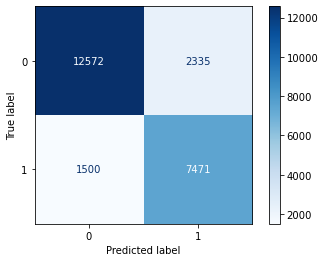

In [171]:
# Classification Report
from sklearn.metrics import f1_score, classification_report

f1_random = f1_score(y_test, y_pred_random)
print(f"f1_score : \n{(100*f1_random):.2f}%")

clf_random = classification_report(y_test, y_pred_random)
print(f"Classification Report : \n{clf_random}")

cm = confusion_matrix(y_test, y_pred_random)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

## Grid Search

In [149]:
params_grid = {'criterion': ['gini', 'entropy'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

params_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 11, 12, 13],
 'min_samples_split': array([1, 2, 3, 4, 5]),
 'min_samples_leaf': array([2, 3, 4, 5, 6, 7])}

In [150]:
from sklearn.model_selection import GridSearchCV

model_grid = DecisionTreeClassifier(max_depth=2, random_state=42)
grid_search = GridSearchCV(model_grid,
                           scoring='accuracy', 
                           verbose=2, 
                           return_train_score=True, 
                           param_grid = params_grid,
                           cv = 3)

In [151]:
%%time
# Fit do grid search
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_sam

[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=3; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=4; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=4; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=4; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=7, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=2, min_samples_split=1; total time=   0.0s
[CV] END c

[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=3; total time=   0.6s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=4; total time=   0.7s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=4; total time=   0.6s
[CV] END criterion=gini, max_depth=11, min_samples_leaf=7, min_samples_split=4; total time=   0.7s
[CV] END c

[CV] END criterion=gini, max_depth=12, min_samples_leaf=6, min_samples_split=4; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=6, min_samples_split=4; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=6, min_samples_split=5; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=6, min_samples_split=5; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=6, min_samples_split=5; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=1; total time=   0.0s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=7, min_samples_split=2; total time=   0.7s
[CV] END c

[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=3; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=4; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=4; total time=   0.8s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=4; total time=   0.7s
[CV] END criterion=gini, max_depth=13, min_samples_leaf=6, min_samples_split=5; total time=   0.8s
[CV] END c

[CV] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=4; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=4; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=5; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=6, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=6, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=6, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=6, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=6, min_samples_split=2;

[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=3; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=3; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=4; total time=   0.6s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=4; total time=   0.7s
[CV] END criterion=entropy, max_depth=11, min_samples_leaf=5, min_samples_split=4;

[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=4; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=4; total time=   0.6s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=4; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=5; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=5; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=4, min_samples_split=5; total time=   0.7s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=5, min_samples_split=1;

[CV] END criterion=entropy, max_depth=13, min_samples_leaf=3, min_samples_split=5; total time=   0.7s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=1; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=2; total time=   0.7s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=2; total time=   0.7s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, max_depth=13, min_samples_leaf=4, min_samples_split=3;

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in 

Wall time: 8min 25s


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 11, 12, 13],
                         'min_samples_leaf': array([2, 3, 4, 5, 6, 7]),
                         'min_samples_split': array([1, 2, 3, 4, 5])},
             return_train_score=True, scoring='accuracy', verbose=2)

In [152]:
# Retorna os melhores parâmetros e o melhor score
grid_search.best_score_

0.8460978294582063

In [153]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [154]:
# Obtém o best_score do treino
acc_grid_search_train = df.sort_values("rank_test_score")['mean_train_score'].iloc[0]
print(f" Acurácia treino: {100*acc_grid_search_train:0.1f}")

# Obtém o best_score da validação
acc_grid_search = grid_search.best_score_
print(f" Acurácia validação: {100*acc_grid_search:0.1f}")

# Retorna o best_estimator_
best_model = grid_search.best_estimator_
# Faz o predict no conjunto de teste
y_pred_grid = best_model.predict(X_test)
print(f" Acurácia teste: {100*accuracy_score(y_test, y_pred_grid):0.1f}")

 Acurácia treino: 86.1
 Acurácia validação: 84.6
 Acurácia teste: 84.0


f1_score : 
79.65 %

Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     14907
           1       0.76      0.83      0.80      8971

    accuracy                           0.84     23878
   macro avg       0.83      0.84      0.83     23878
weighted avg       0.84      0.84      0.84     23878




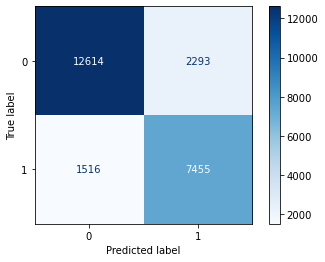

In [155]:
# Classification Report
from sklearn.metrics import classification_report

f1_grid = f1_score(y_test, y_pred_grid)
print(f"f1_score : \n{(100*f1_grid):.2f} %")
print()
f1_grid = classification_report(y_test, y_pred_grid)
print(f"Classification Report : \n{f1_grid}")
print()
cm = confusion_matrix(y_test, y_pred_grid)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

## Pipeline

In [56]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [32]:
# Separar por categóricos e numéricos
num_cols = X_train.select_dtypes(include='number').columns
cat_cols =  X_train.select_dtypes(exclude='number').columns
categorical_features = np.array([i for i,x in enumerate(X_train.columns) if x in list(cat_cols)])

In [33]:
# Tratamento das variáveis categóricas
cat_pipe = Pipeline([
    ("cat", OneHotEncoder(sparse=False))
])

In [47]:
# preprocessor
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_cols)
], remainder = "passthrough")
preprocessor.fit_transform(X_train)

array([[1., 0., 0., ..., 3., 0., 1.],
       [1., 0., 0., ..., 2., 0., 1.],
       [1., 0., 0., ..., 2., 0., 1.],
       ...,
       [1., 0., 0., ..., 3., 0., 1.],
       [0., 1., 0., ..., 7., 0., 1.],
       [0., 1., 0., ..., 2., 0., 1.]])

In [48]:
# Pipeline principal
pipe_dt = Pipeline([
        ('over', SMOTENC(random_state=42, categorical_features=categorical_features)),
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(max_depth = 10, random_state = 42))
])

In [49]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('over',
                 SMOTENC(categorical_features=array([ 0,  2,  3,  4,  5,  6,  9, 10, 12]),
                         random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'deposit_type', 'agent', 'customer_type'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [52]:
y_pred_pipe = pipe_dt.predict(X_test)

f1_score : 
78.60 %

Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14907
           1       0.78      0.79      0.79      8971

    accuracy                           0.84     23878
   macro avg       0.83      0.83      0.83     23878
weighted avg       0.84      0.84      0.84     23878




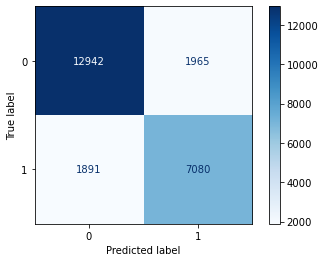

In [57]:
from sklearn.metrics import classification_report

f1_grid = f1_score(y_test, y_pred_pipe)
print(f"f1_score : \n{(100*f1_grid):.2f} %")
print()
f1_grid = classification_report(y_test, y_pred_pipe)
print(f"Classification Report : \n{f1_grid}")
print()
cm = confusion_matrix(y_test, y_pred_pipe)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [58]:
# grid parameters
grid_dt = {
        'dt__criterion': ['entropy', 'gini'],
        'dt__max_depth': list(np.arange(10, 14)),
        'dt__min_samples_leaf': np.arange(2, 8),
        'dt__min_samples_split': np.arange(1, 6),
    }

In [ ]:
# 5 folds
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
# Random search (ou Grid Search, mas o Random traz uma boa aproximação)
random_search = RandomizedSearchCV(pipe_dt, param_distributions = grid_dt, cv=kfold, scoring = "f1", n_jobs = 2)
random_search.fit(X_train, y_train)